## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [1]:
import os
import sys
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Adding the parent directory to the path to enable importing
root_dir = os.path.dirname(os.path.abspath("../"))
if root_dir not in sys.path:
    sys.path.append(root_dir)

import DDQN.DDQN as ddqn
from DDQN.DDQN import DDQNAgent
from DDQN.trainer import Stats, Round, CustomHockeyMode, train_ddqn_agent
import hockey.hockey_env as h_env


reload(h_env)
reload(ddqn)

/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'DDQN.DDQN' from '/home/kivanc/ders/RL/project/RL-Hockey/DDQN/DDQN.py'>

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Training

### Environment & Agent Initialization

In [3]:
env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

In [4]:
DISCOUNT = 0.90
EPS = 0.2
UPDATE_TARGET_FREQ = 20
TAU = 1e-3

agent_player = DDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    hidden_sizes=[256, 256],
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU
)

agent_opp_weak = h_env.BasicOpponent(weak=True)
agent_opp_strong = h_env.BasicOpponent(weak=False)

In [5]:
# For the visualisation of the training progress
stats = Stats()

### Training

Choose a training scheme:

In [ ]:
rounds = [
    Round(100, agent_opp_weak, CustomHockeyMode.NORMAL),
    Round(200, agent_opp_strong, CustomHockeyMode.NORMAL),
    Round(50, agent_opp_weak, CustomHockeyMode.SHOOTING),
    Round(50, agent_opp_weak, CustomHockeyMode.DEFENSE),
    Round(100, agent_opp_strong, CustomHockeyMode.RANDOM_SHOOTING_DEFENSE),
    Round(100, agent_opp_strong, CustomHockeyMode.RANDOM_ALL),
]

In [7]:
rounds = [
    Round(100, agent_opp_weak, CustomHockeyMode.NORMAL),
    Round(200, agent_opp_strong, CustomHockeyMode.NORMAL)
]

Execute training:

In [8]:
train_ddqn_agent(
    agent_player,
    env,
    max_steps=1000,
    rounds=rounds,
    stats=stats,
    ddqn_iter_fit=64,
    print_freq=100,
    tqdm=tqdm,
    verbose=True
)

Begin round 1 with mode Mode.NORMAL for 100 episodes


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 | Return: -15.559293048471137 | Loss: 0.007599026430398226 | Done in 126 steps
Episode 100 | Return: -13.203507424641378 | Loss: 0.008595077320933342 | Done in 69 steps
Begin round 2 with mode Mode.NORMAL for 200 episodes


  0%|          | 0/200 [00:00<?, ?it/s]

Episode 1 | Return: 3.485458585184456 | Loss: 0.03319161757826805 | Done in 153 steps
Episode 101 | Return: 5.97760842886759 | Loss: 0.013985292986035347 | Done in 184 steps
Episode 200 | Return: -13.48623185577593 | Loss: 0.007731910329312086 | Done in 77 steps


## Agent Model Saving

In [ ]:
STATE_PATH = "../models/hockey_mixed_dev/"

reload(ddqn)

agent_player.save_state(STATE_PATH)

## Visualization

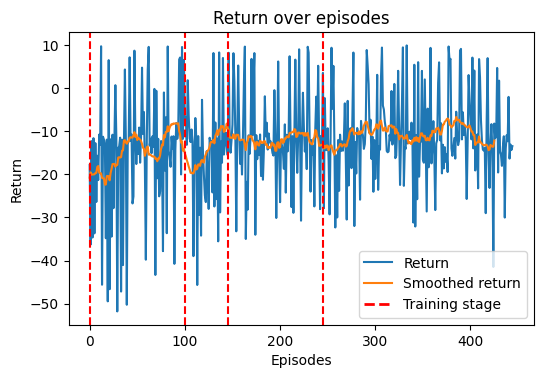

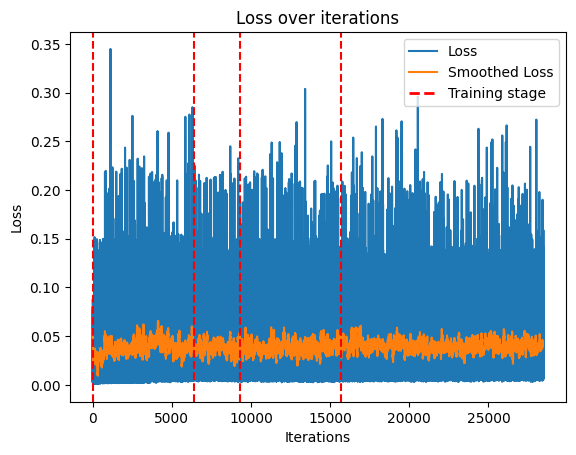

In [10]:
returns_np = np.asarray(stats.returns)
losses_np = np.asarray(stats.losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(returns_np[:,1], label="Return")
plt.plot(running_mean(returns_np[:,1],20), label="Smoothed return")
for xc in stats.returns_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Return over episodes")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np, label="Loss")
plt.plot(running_mean(losses_np, 50), label="Smoothed Loss")
for xc in stats.losses_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

### Rendered Demonstration Against Strong Opponent

For a more detailed evaluation, refer to `ddqn-hockey-eval.ipynb`.

In [11]:
obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_opp = env.obs_agent_two()

done = False
trunc = False
step = 0
while not (done or trunc):
    step += 1
    env.render()
    
    a1_discr = agent_player.act(obs)
    a1 = env.discrete_to_continous_action(a1_discr)
    a2 = agent_opp_strong.act(obs_opp)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_opp = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {step} steps")
        break

Episode done in 251 steps


In [12]:
env.close()